# Tutorial: Sliding Window Analysis of Non-Linear Timeseries

This tutorial aims to show how regime shifts in non-linear timeseries with help of a sliding window recurrence analysis. The application of corresponding methods in the __pyunicorn__ package is illustrated with some examples.


## 1. Introduction

- Tutorial uses methods that are introduced in the RecurrenceNetwork and VisibilityGraph Tutorials.

### 1.1 The idea of applying a sliding window and what it is good for

- detecting regime shifts

### 1.2 Measures calculated

For each of our sliding windows, we will calculate various measures that are briefly re-introduced in this section. For more extensive definitions see Marwan et al. (2021).

_Recurrence Plots_ show all points $i$ in a timeseries that recur at some other point $j$ in the timeseries. This way, we obtain the recurrence matrix $R_{ij}$. From a given recurrence plot, a histogram of diagonal line lengths $P(l)$ can be retrieved. The __determinism__ $DET$ of a timeseries is defined by the fraction of recurrence points that form diagonal lines of at least length $l_{min}$:

$$DET = \frac{\sum_{l=l_{min}}^N lP(l)}{\sum_{l=1}^N lP(l)}$$

Similarly, from the distribution of vertical line lengths $P(v)$, the timeseries' __laminarity__ $LAM$ can be calculated as

$$LAM = \frac{\sum_{v=v_{min}}^N vP(v)}{\sum_{v=1}^N vP(v)}$$

_Recurrence Networks_ can be created from recurrence plots. By identifying the recurrence matrix $R_{i,j}$ with the link matrix $A_{i,j}$ of a network, we can apply network measures to our timeseries. We subtract the identity line to exclude self-loops and obtain $A_{i,j} = R_{i,j} - \delta_{i,j}$ (with the Kronecker-Delta $\delta_{i,j}$). The __transitivity__  $\mathcal{T}$ of a network measures the probability of two neighbors (i.e. recurrences) $j$ and $k$ of any state $i$ also being neighbors themselves. It can be calculated as

$$\mathcal{T} = \frac{\sum_{i,j,k=1}^N A_{i,j}A_{j,k}A_{k,i}}{\sum_{i,j,k=1}^N A_{i,j}A_{k,i}}$$

The minimum number of links that have to be crossed to travel from one node to another is called the pathlength $\ell_{i,j}$. We can calcuate the __average path length__ $\mathcal{L}$ as

$$\mathcal{L} = \frac{1}{N(N-1)} \sum_{i,j=1}^N \ell_{i,j}$$ 

_Visibility Graphs (VG)_ are helpful in the detection of regime shifts by checking for __reversibility__ of a given phase space trajectory. If backward and forward (retarded and advanced) visibility links are equally distributed, the time series is reversible. We can check for this by calculating the probability distributions of the retarded and the advanced degree $\rho(k^r)$ and $\rho(k^a)$. Performing a two sample Kolmogorov-Smirnov (KS) test on the two distributions, we obtain the p-value $p(k)$ to assess whether the null-hypothesis of reversibility can be rejected. The same analysis can be performed with the retarded and advanced clustering coefficients $C^r$ and $C^a$ to obtain $p(C)$.

### Literature

- [Donges et al. (2011): Identification of dynamical transitions in marine palaeoclimate records by recurrence network analysis](https://doi.org/10.5194/npg-18-545-2011)

- [Donges et al. (2015): Non-linear regime shifts in Holocene Asian monsoon variability: potential impacts on cultural change and migratory patterns](https://doi.org/10.5194/cp-11-709-2015)

- [Marwan et al. (2021): Nonlinear time series analysis of palaeoclimate proxy records](https://doi.org/10.1016/j.quascirev.2021.107245)

## 2. Examples 

### 2.1 Logistic Map

First we import the necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp # to perform two-sample KS-test
#from tqdm.auto import tqdm # 
from pyunicorn.timeseries import RecurrenceNetwork, VisibilityGraph

#### 2.1.1 Prepare timeseries

In [2]:
def logistic_map(x0, r, N, spinup=100):
    """
    Returns a time series of length T using the logistic map
    x_(n+1) = r*x_n(1-x_n) at parameter r and using the initial condition x0.

    INPUT: x0 - Initial condition, 0 <= x0 <= 1
            r - Bifurcation parameter, 0 <= r <= 4
            N - length of the desired time series
            spinup - number of spinup-timesteps before storing results to output
    OUTPUT: numpy array of timeseries under given parameters
    """
    # spinup
    for n in range(spinup):
        x0 = r * x0 * (1 - x0)

    #  Initialize timeSeries as python list with initial condition as first entry
    timeseries = [x0]

    for n in range(N):
        # get current timestep value
        xn = timeseries[n]
        # calculate next timestep value
        xstep = r * xn * (1 - xn)
        # append new timestep value to timeseries
        timeseries.append(xstep)

    return np.array(timeseries)

Then we calculate an example timeseries with some interesting parameters

Text(0, 0.5, '$x_n$')

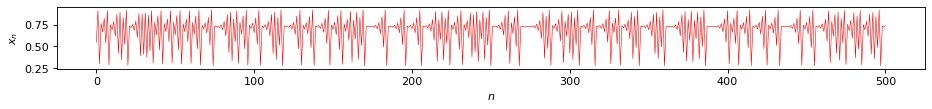

In [3]:
#  Parameters of logistic map
r = 3.679  # Bifurcation parameter
x0 = 0.7   # Initial value

#  Length of the time series
N = 500

#Generate the timeseries
x = logistic_map(x0, r, N)

#  Plot the time series
plt.figure(figsize=(14, 1), dpi=80)
plt.plot(x, "r", lw=.5)
plt.xlabel("$n$")
plt.ylabel("$x_n$")

#### 2.1.2 Perform sliding window analysis

In [4]:
def sliding_window(x, min_t, max_t, win_size, overlap, rr=0.05, d=1, t=0, HORIZONTAL=False):
    win = np.arange(min_t ,max_t-win_size,overlap)  # array of windows

    # intitialize list for each measure
    w = []   # window center
    DET = [] # determinism
    LAM = [] # laminarity
    T = []   # transitivity
    L = []   # average path length
    p_k = [] # irreversibility stats: degree
    p_C = [] # irreversibility stats: local clustering

    for i in win:
        #print(int((i+overlap)/overlap),'/',len(win))
        # Arranging the windowed time series
        x_win = x[i:(i+win_size)]

        # calculate recurrence network for RQA and RNA measures
        net = RecurrenceNetwork(x_win, recurrence_rate=rr, silence_level=3, dim = d, tau=t)

        # calculate visibility graph for VG measures
        vg = VisibilityGraph(x_win, horizontal=HORIZONTAL, silence_level=3)
        l_k_obs = vg.retarded_degree()
        r_k_obs = vg.advanced_degree()
        l_C_obs = vg.retarded_local_clustering()
        r_C_obs = vg.advanced_local_clustering()

        # store results
        w.append(i + win_size/2)
        DET.append(net.determinism())
        LAM.append(net.laminarity())
        T.append(net.transitivity())
        L.append(net.average_path_length())
        p_k.append(ks_2samp(l_k_obs, r_k_obs)[1]) # get p-value of 2-sample KS test
        p_C.append(ks_2samp(l_C_obs, r_C_obs)[1]) # get p-value of 2-sample KS test

    del x_win, net

    return w, DET, LAM, T, L, p_k, p_C

In [5]:
# sliding window parameters
min_t = 0
max_t = N

win_size = 50               # window size for sliding windows
overlap = int(win_size/10)  # overlap of sliding windows

# evaluation parameters
#  Recurrence Plot
rr = 0.05                   # fixed recurrence rate
d = 1                       # embedding dimension
t = 0                       # embedding delay

#  Visibility Graph
#   toggle horizontal VG (faster)
HORIZONTAL = False

In [6]:
# call slinding_window function
w, DET, LAM, T, L, p_k, p_C = sliding_window(
    x,                      # timeseries to analyze
    min_t=min_t,            # start timestep
    max_t=max_t,            # end timestep
    win_size=win_size,      # window size
    overlap=overlap,        # overlap of sliding windows (e.g. win_size/10)
    rr=rr,                  # fixed recurrence rate
    d=d,                    # embedding dimension
    t=t,                    # embedding delay
    HORIZONTAL=HORIZONTAL   # toggle horizontal visibility graph (faster)
)

#### 2.1.3 Plot results

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8j/pr33ty9n1wz1gnjmz1v7khzm0000gn/T/ipykernel_15261/3486820508.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathcal{T}$',fontsize=14)
/var/folders/8j/pr33ty9n1wz1gnjmz1v7khzm0000gn/T/ipykernel_15261/3486820508.py:31: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathcal{L}$',fontsize=14)


Text(0.5, 0, 'timesteps $n$')

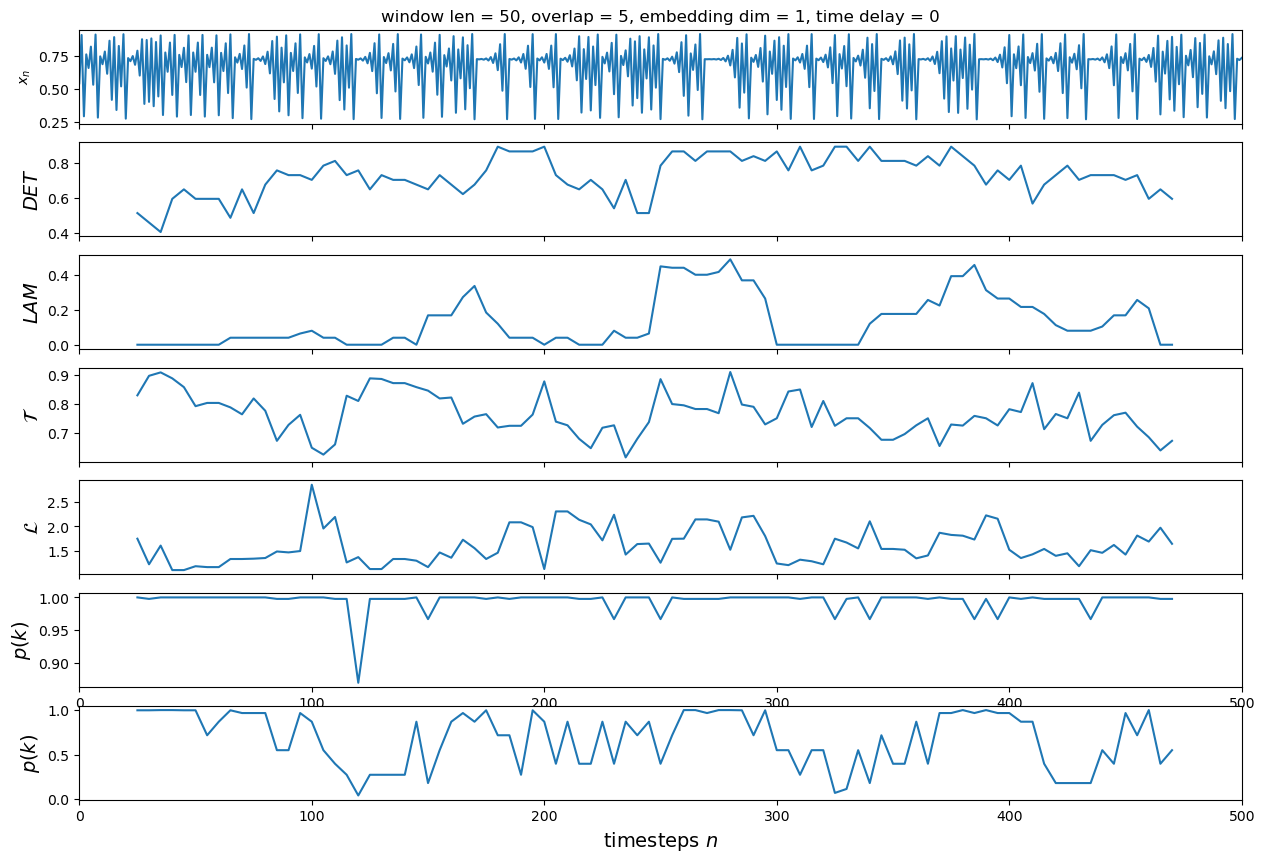

In [8]:
fig = plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
ax = plt.subplot2grid((7,1), (0,0))
plt.plot(x)
plt.ylabel('$x_n$')
plt.title('window len = ' + str(win_size) + ', overlap = ' + str(overlap)+', embedding dim = ' + str(d) + ', time delay = ' + str(t))
plt.xlim(min_t,max_t)
ax.set_xticklabels([])

ax = plt.subplot2grid((7,1), (1,0))
plt.plot(w, DET)
plt.xlim(min_t,max_t)
ax.set_xticklabels([])
plt.ylabel('$DET$',fontsize=14)

ax = plt.subplot2grid((7,1), (2,0))
plt.plot(w, LAM)
plt.xlim(min_t,max_t)
ax.set_xticklabels([])
plt.ylabel('$LAM$',fontsize=14)

ax = plt.subplot2grid((7,1), (3,0))
plt.plot(w, T)
plt.xlim(min_t,max_t)
ax.set_xticklabels([])
plt.ylabel('$\mathcal{T}$',fontsize=14)

ax = plt.subplot2grid((7,1), (4,0))
plt.plot(w, L)
plt.xlim(min_t,max_t)
ax.set_xticklabels([])
plt.ylabel('$\mathcal{L}$',fontsize=14)

plt.subplot2grid((7,1), (5,0))
plt.plot(w, p_k)
plt.xlim(min_t,max_t)
plt.ylabel('$p(k)$',fontsize=14)

plt.subplot2grid((7,1), (6,0))
plt.plot(w, p_C)
plt.xlim(min_t,max_t)
plt.ylabel('$p(C)$',fontsize=14)

plt.xlabel('timesteps $n$',fontsize=14)

Discuss these results to see whether you have understood what we have done. Feel free to consult the above literature and try different parameter settings for comparison!

### 2.2 Lorenz attractor
- check for differences with 3D timeseries
- include time delay embedding

In a next step, we will apply our moving window method to a three dimensional dynamical system: The Lorenz attractor. It is defined by
$$\frac{d}{dt}(x,y,z)=\left(10(y-x)\right(28-z),xy-\frac{8}{3}z)$$

#### 2.2.1 Prepare Timeseries

In [9]:
def Lorenz(dt=0.01, num_steps=10000, x0=0., y0=1., z0=1.05, s=10., r=28., b=2.667, spinup=100):
   """
   Given:
      dt: length of timestep
      num_steps: number of timesteps
      x0, y0, z0: initial values for timeseries
      s, r, b: parameters defining the lorenz attractor
      spinup: number of spinup-timesteps before storing results to output
   Returns:
      timeseries: numpy array of three dimensional timeseries on Lorenz attractor with length num_steps
   """
   
   # spinup
   for n in range(spinup):
      x0 += (s*(y0 - x0)) * dt
      y0 += (r*x0 - y0 - x0*z0) * dt
      z0 += (x0*y0 - b*z0) * dt

   # initialize timeseries with spun-up initial values
   x = [x0]
   y = [y0]
   z = [z0]

   # calculate timeseries
   for n in range(num_steps-1):
      # get current values
      xn = x[n]
      yn = y[n]
      zn = z[n]
      # calculate next timestep values
      xstep = xn + (s*(yn - xn)) * dt
      ystep = yn + (r*xn - yn - xn*zn) * dt
      zstep = zn + (xn*yn - b*zn) * dt
      # append to timeseries
      x.append(xstep)
      y.append(ystep)
      z.append(zstep)

   timeseries = np.transpose([x,y,z])
   
   return timeseries

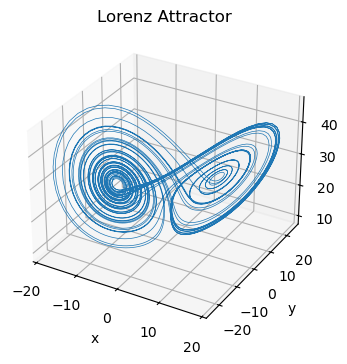

In [10]:
# calculate timeseries on Lorenz attractor 
N = 5000

X = Lorenz(num_steps=N, spinup=100)

# Plot
ax = plt.figure(figsize=(14,4)).add_subplot(projection='3d')

ax.plot(X[:,0], X[:,1], X[:,2], lw=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Lorenz Attractor")

plt.show()

#### 2.2.2 Perform sliding window analysis

To make things more interesting, we will now perform a time delay embedding on our sample timeseries.

Also, with our now three-dimensional timeseries we need to switch up things a bit.

In [11]:
def sliding_window_3D(x, min_t, max_t, win_size, overlap, dim = 3, rr=0.05, d=1, t=0, HORIZONTAL=False):
    win = np.arange(min_t ,max_t-win_size,overlap)  # array of windows

    # intitialize list for each measure
    w = []   # window center
    DET = [] # determinism
    LAM = [] # laminarity
    T = []   # transitivity
    L = []   # average path length
    p_k = [] # irreversibility stats: degree
    p_C = [] # irreversibility stats: local clustering

    for i in win:
        #print(int((i+overlap)/overlap),'/',len(win))
        # Arranging the windowed time series
        x_win = x[i:(i+win_size)] # TODO: adapt slicing to 3D array

        # calculate recurrence network for RQA and RNA measures
        net = RecurrenceNetwork(x_win, recurrence_rate=rr, silence_level=3, dim = d, tau=t)

        # calculate visibility graph for VG measures
        vg = VisibilityGraph(x_win, horizontal=HORIZONTAL, silence_level=3)
        l_k_obs = vg.retarded_degree()
        r_k_obs = vg.advanced_degree()
        l_C_obs = vg.retarded_local_clustering()
        r_C_obs = vg.advanced_local_clustering()

        # store results
        w.append(i + win_size/2)
        DET.append(net.determinism())
        LAM.append(net.laminarity())
        T.append(net.transitivity())
        L.append(net.average_path_length())
        p_k.append(ks_2samp(l_k_obs, r_k_obs)[1]) # get p-value of 2-sample KS test
        p_C.append(ks_2samp(l_C_obs, r_C_obs)[1]) # get p-value of 2-sample KS test

    del x_win, net

    return w, DET, LAM, T, L, p_k, p_C

In [12]:
# sliding window parameters
min_t = 0
max_t = N

win_size = 500               # window size for sliding windows
overlap = int(win_size/10)  # overlap of sliding windows

# evaluation parameters
#  Recurrence Plot
rr = 0.05                   # fixed recurrence rate
d = 1                       # embedding dimension
t = 0                       # embedding delay

#  Visibility Graph
#   toggle horizontal VG (faster)
HORIZONTAL = False

In [ ]:
# call slinding_window function
w, DET, LAM, T, L, p_k, p_C = sliding_window_3D(
    X,                      # timeseries to analyze
    min_t=min_t,            # start timestep
    max_t=max_t,            # end timestep
    win_size=win_size,      # window size
    overlap=overlap,        # overlap of sliding windows (e.g. win_size/10)
    rr=rr,                  # fixed recurrence rate
    d=d,                    # embedding dimension
    t=t,                    # embedding delay
    HORIZONTAL=HORIZONTAL   # toggle horizontal visibility graph (faster)
)

#### 2.2.3 Plot results

In [ ]:
plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
plt.subplot2grid((7,1), (0,0))
plt.plot(x)
plt.ylabel('$x_n$')
plt.title('window len = ' + str(win_size) + ', overlap = ' + str(overlap)+', embedding dim = ' + str(d) + ', time delay = ' + str(t))
plt.xlim(min_t,max_t)

plt.subplot2grid((7,1), (1,0))
plt.plot(w, DET)
plt.xlim(min_t,max_t)
plt.ylabel('$DET$',fontsize=14)

plt.subplot2grid((7,1), (2,0))
plt.plot(w, LAM)
plt.xlim(min_t,max_t)
plt.ylabel('$LAM$',fontsize=14)

plt.subplot2grid((7,1), (3,0))
plt.plot(w, T)
plt.xlim(min_t,max_t)
plt.ylabel('$\mathcal{T}$',fontsize=14)

plt.subplot2grid((7,1), (4,0))
plt.plot(w, L)
plt.xlim(min_t,max_t)
plt.ylabel('$\mathcal{L}$',fontsize=14)

plt.subplot2grid((7,1), (5,0))
plt.plot(w, p_k)
plt.xlim(min_t,max_t)
plt.ylabel('$p(k)$',fontsize=14)

plt.subplot2grid((7,1), (6,0))
plt.plot(w, p_C)
plt.xlim(min_t,max_t)
plt.ylabel('$p(C)$',fontsize=14)

plt.xlabel('timesteps $n$',fontsize=14)

### 2.3 Paleoclimate Record

- use ODP 659 (SST and $\delta^{18}O$ from Atlantic Ocean offshore subtropical West Africa)
- embedding more complicated due to irregular timesteps, see Marwan et al. 2021
